In [1]:
from prior import get_prior

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)
import functools

INFO[2023-06-12 14:53:58,296]: Remote TPU is not linked into jax; skipping remote TPU.
INFO[2023-06-12 14:53:58,297]: Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO[2023-06-12 14:53:58,297]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-12 14:53:58,297]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-06-12 14:53:58,298]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO[2023-06-12 14:53:58,298]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft


In [2]:
"""
MAKING THE DATA
"""

Times = np.linspace(0,1,256)

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# Build Gp
def build_gp(kernel_params, mean_params, t, kernel_type, mean_type = "gaussian"):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = 2*jnp.pi*kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
    
    # Using partial to make the mean so that it only takes the time value
    if mean_type == "gaussian":
        mean = functools.partial(gaussian, mean_params = mean_params)
        return tinygp.GaussianProcess( kernel, t, mean=mean)
    elif mean_type == "constant":
        mean = mean_params
        return tinygp.GaussianProcess( kernel, t)

hqpoparams = {
    "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,
}

lqpoparams = {
    "arn" : jnp.exp(4.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),    "cqpo": jnp.exp(1),    "freq": 20,
}

hqpokernel = kernels.quasisep.Exp(
    scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = 2*jnp.pi*hqpoparams["freq"])

mean_params = {
    "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}

hqpogp = build_gp(hqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")
lqpogp = build_gp(lqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")

lightcurve_vals = lqpogp.sample(jax.random.PRNGKey(101))
lightcurve = Lightcurve(Times, lightcurve_vals)

INFO[2023-06-12 14:54:04,477]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-06-12 14:54:04,478]: Checking if light curve is sorted.
INFO[2023-06-12 14:54:04,478]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [3]:
print(len(lightcurve.counts))

256


In [4]:
"""
GETTING RESULTS
"""

parameters = {
                # "kernel_type" : "qpo_plus_red_noise",
                # "mean_type" : "gaussian",
                "Times" : Times,
                "counts" : lightcurve_vals,
                "diag" : 0.1,
                "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
                "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,
                "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}

from GP import GP

model_type = ("QPO_plus_RN", "gaussian")

gp = GP(Lc = lightcurve, Model_type = model_type, Model_params = parameters)


In [5]:
print(gp.maingp)
print(gp.maingp.kernel)
print(len(gp.maingp.X))
print(type(gp.maingp.X))

Sum(kernel1=Exp(scale=Array(0.36787944, dtype=float64, weak_type=True), sigma=Array(1.64872127, dtype=float64, weak_type=True)), kernel2=Celerite(a=Array(0.67032005, dtype=float64, weak_type=True), b=0.0, c=Array(2.71828183, dtype=float64, weak_type=True), d=125.66370614359172))
256
<class 'numpy.ndarray'>


In [6]:
gp.get_logprob()

Array(-777.98391035, dtype=float64)

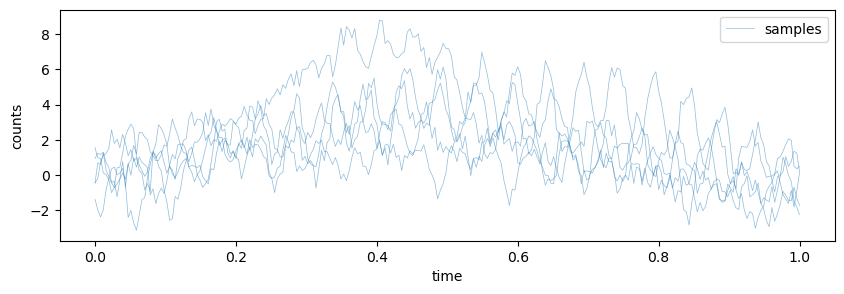

In [7]:
# Xtest = jnp.linspace(0,1,512)
gp.plot_originalgp(sample_no = 5, seed = 4)

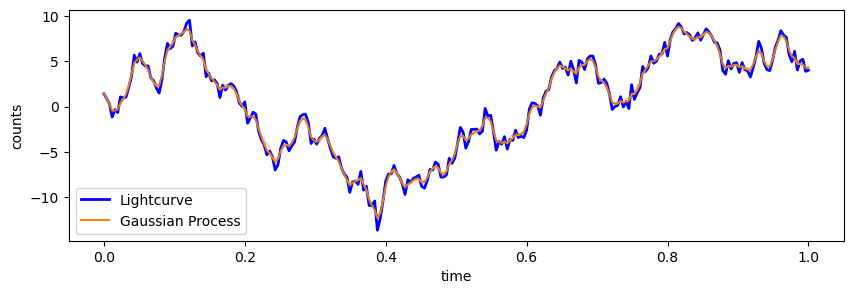

In [8]:
gp.plot_gp(sample_no = 4, seed = 3)

In [9]:
from GP import GPResult

gpresult = GPResult(gp, prior_type = ("QPO_plus_RN", "gaussian"), prior_parameters=parameters)

In [10]:
print(len(gpresult.lc.time))
print(len(gpresult.lc.counts))

256
256


In [11]:
gpresult.run_sampling()

<function get_prior.<locals>.QPOprior_model at 0x1626df160>
arn	() -> () <class 'numpy.float64'>
crn	() -> () <class 'numpy.float64'>
aqpo	() -> () <class 'numpy.float64'>
cqpo	() -> () <class 'numpy.float64'>
freq	() -> () <class 'numpy.float64'>
A	() -> () <class 'numpy.float64'>
t0	() -> () <class 'numpy.float64'>
sig	() -> () <class 'numpy.float64'>
<PjitFunction of <function get_likelihood.<locals>.QPOlog_likelihood at 0x163f36040>>


INFO[2023-06-12 14:54:23,058]: Sanity check...
INFO[2023-06-12 14:54:23,365]: Sanity check passed


TypeError: body_fun output and input must have identical types, got
(UniDimProposalState(key='ShapedArray(uint32[2])', process_step='ShapedArray(int32[])', proposal_count='ShapedArray(int32[])', num_likelihood_evaluations='ShapedArray(int32[])', point_U0='ShapedArray(float32[8])', log_L0='ShapedArray(float32[])', direction='ShapedArray(float32[8])', left='DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', right='DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', point_U='ShapedArray(float32[8])', t='ShapedArray(float32[])', log_L_constraint='ShapedArray(float64[])'), 'ShapedArray(float32[])').